In [ ]:
import os
import sys
import random
import numpy as np
import pandas as pd
import cv2

In [ ]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Import necessary items from Keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.models import load_model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.layers import Activation,AveragePooling2D ,ReLU ,Add,Dense,Reshape,Multiply, Dropout, UpSampling2D,Conv2D,MaxPooling2D,concatenate,add,GlobalAveragePooling2D,GlobalMaxPool2D,Multiply

In [ ]:
train_images =np.load("/content/drive/MyDrive/CMPT733/project/image_mixed.npy").astype(np.float32)
labels = np.load("/content/drive/MyDrive/CMPT733/project/label_mixed.npy").astype(np.float32)
train_images = np.array(train_images)
labels = np.array(labels)
labels = labels / 255
train_images, labels = shuffle(train_images, labels)
# X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.3)
X_train, X_test, y_train, y_test = train_test_split(train_images, labels, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
batch_size = 32
epochs = 100
pool_size = (2, 2)
input_shape = X_train.shape[1:]
y_train=y_train.reshape(y_train.shape[0],80,160,1)
y_val=y_val.reshape(y_val.shape[0],80,160,1)
print(X_val.shape)
print(y_val.shape)

(2400, 80, 160, 3)
(2400, 80, 160, 1)


In [ ]:
import keras.backend as K

def dsc(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dsc(y_true, y_pred)



def IOU(y_true, y_pred):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    thresh = 0.5

    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')

    union = K.sum(K.maximum(y_true, y_pred)) + K.epsilon()
    intersection = K.sum(K.minimum(y_true, y_pred)) + K.epsilon()

    iou = intersection/union

    return iou

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras import layers
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model
from keras.applications import ResNet50,MobileNetV2
def deconv(x, kernelsize,fi):
    #fi=x.shape[-1]
    fx = Conv2DTranspose(fi, kernelsize, activation='relu', padding='same')(x)
    fx = BatchNormalization()(fx)
    fx =Conv2DTranspose(fi, kernelsize, padding='same')(fx)
    out = BatchNormalization()(fx)
    return out

# LLDNet

In [ ]:
# LLDNet
def CBAM (x,r):
    
    ###### Channel Attention ##########
    f=x.shape[-1]
    a_pool = GlobalAveragePooling2D()(x)
    m_pool = GlobalMaxPool2D()(x) 
    Dense_layer1 = Dense (f // r , activation = 'relu') 
    Dense_layer2 = Dense (f, activation = 'relu') 
    avg_out = Dense_layer2 (Dense_layer1(a_pool)) 
    max_out = Dense_layer2 (Dense_layer1( m_pool))
    channel = add([ avg_out,max_out]) 
    channel = Activation('sigmoid') (channel) 
    channel = Reshape ((1,1,f)) (channel)  
    C_out = Multiply()([x,channel])
   
    
                      
    ###### Spatial Attention ########
    av_pooling=AveragePooling2D(pool_size=(1,1))(C_out)
    ma_pooling=MaxPooling2D(pool_size=(1,1))(C_out)
    spatial=concatenate([av_pooling,ma_pooling], axis = 3)
    spatial =Conv2D(1,(7,7),strides=1,padding ='same') (spatial) 
    #spatial=ASPP(x,spatial)
    
    spatial= Activation('sigmoid')(spatial)
      
    S_out = Multiply()([C_out,spatial])
    
    return S_out

In [ ]:
# LLDNet Resblock
from keras import layers
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model
from keras.applications import ResNet50,MobileNetV2

def resblock(x, fi):
    fx = Conv2D(fi, 3, activation='relu', padding='same')(x)
    fx = BatchNormalization()(fx)
    fx =Conv2D(fi, 3, padding='same')(fx)

    x=Conv2D(1,1, activation='relu', padding='same')(x)
    
    out = Add()([x,fx])
    out = ReLU()(out)
    out = BatchNormalization()(out)
    return out

In [ ]:
# LLDNet Resblock with deeper ResBlocks
from keras import layers
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model
from keras.applications import ResNet50,MobileNetV2

def resblock(x, fi):
    fx = Conv2D(fi, 3, activation='relu', padding='same')(x)
    fx = BatchNormalization()(fx)
    fx =Conv2D(fi, 3, padding='same')(fx)
    fx = BatchNormalization()(fx)
    fx =Conv2D(fi, 5, padding='same')(fx)
    fx = BatchNormalization()(fx)
    fx =Conv2D(fi, 3, padding='same')(fx)

    x=Conv2D(1,1, activation='relu', padding='same')(x)
    
    out = Add()([x,fx])
    out = ReLU()(out)
    out = BatchNormalization()(out)
    return out

In [ ]:
# LLDNet Resblock simplified
from keras import layers
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model
from keras.applications import ResNet50,MobileNetV2

def resblock(x, fi):
    fx = Conv2D(fi, 3, activation='relu', padding='same')(x)
    fx = BatchNormalization()(fx)

    x=Conv2D(1,1, activation='relu', padding='same')(x)
    
    out = Add()([x,fx])
    out = ReLU()(out)
    out = BatchNormalization()(out)
    return out

In [ ]:
# LLDNet
inputs = keras.layers.Input((80,160,3))

block1=resblock(inputs,8)
# block1=resblock(inputs,3,5,8)

pool1 = MaxPooling2D(pool_size=(2, 2),name="pool1")(block1)
    
block2=resblock(pool1,16)
# block2=resblock(pool1,3,5,16)

pool2 = MaxPooling2D(pool_size=(2, 2),name="pool2")(block2)
    
block3=resblock(pool2,32)
# block3=resblock(pool2,3,5,32)

pool3 = MaxPooling2D(pool_size=(2, 2),name="pool3")(block3)


block4=resblock(pool3,64)
# block4=resblock(pool2,3,5,32)

pool4 = MaxPooling2D(pool_size=(2, 2),name="pool4")(block4)



a1=CBAM (pool1,8)

a2=CBAM (pool2,8)

a2=UpSampling2D(size = (2,2))(a2)
c1=concatenate([a1,a2], axis = 3)



a3=CBAM (pool3,8)

a4=CBAM (pool4,8)


a4=UpSampling2D(size = (2,2))(a4)
c2=concatenate([a3,a4], axis = 3)
c2=UpSampling2D(size = (2,2))(c2)




c1=UpSampling2D(size = (2,2))(c1)
D1=deconv(c1, 3,32)

c2=UpSampling2D(size = (4,4))(c2)
D2=deconv(c2, 3,16)


pool4=UpSampling2D(size = (16,16))(pool4)
D3=deconv(pool4, 3,8)




D=concatenate([D1,D2,D3], axis = 3)


O= Conv2DTranspose(1, 1, activation = 'sigmoid')(D)


In [ ]:
# LLD
model = Model(inputs, O)
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)
opt = keras.optimizers.Adam()
model.compile(optimizer=opt,  loss = "binary_crossentropy", metrics = ['dsc','accuracy', 'IOU','precision_m', 'recall_m', 'f1_m'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 80, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 80, 160, 8)   224         ['input_2[0][0]']                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 80, 160, 1)   4           ['input_2[0][0]']                
                                                                                                  
 batch_normalization_14 (BatchN  (None, 80, 160, 8)  32          ['conv2d_12[0][0]']        

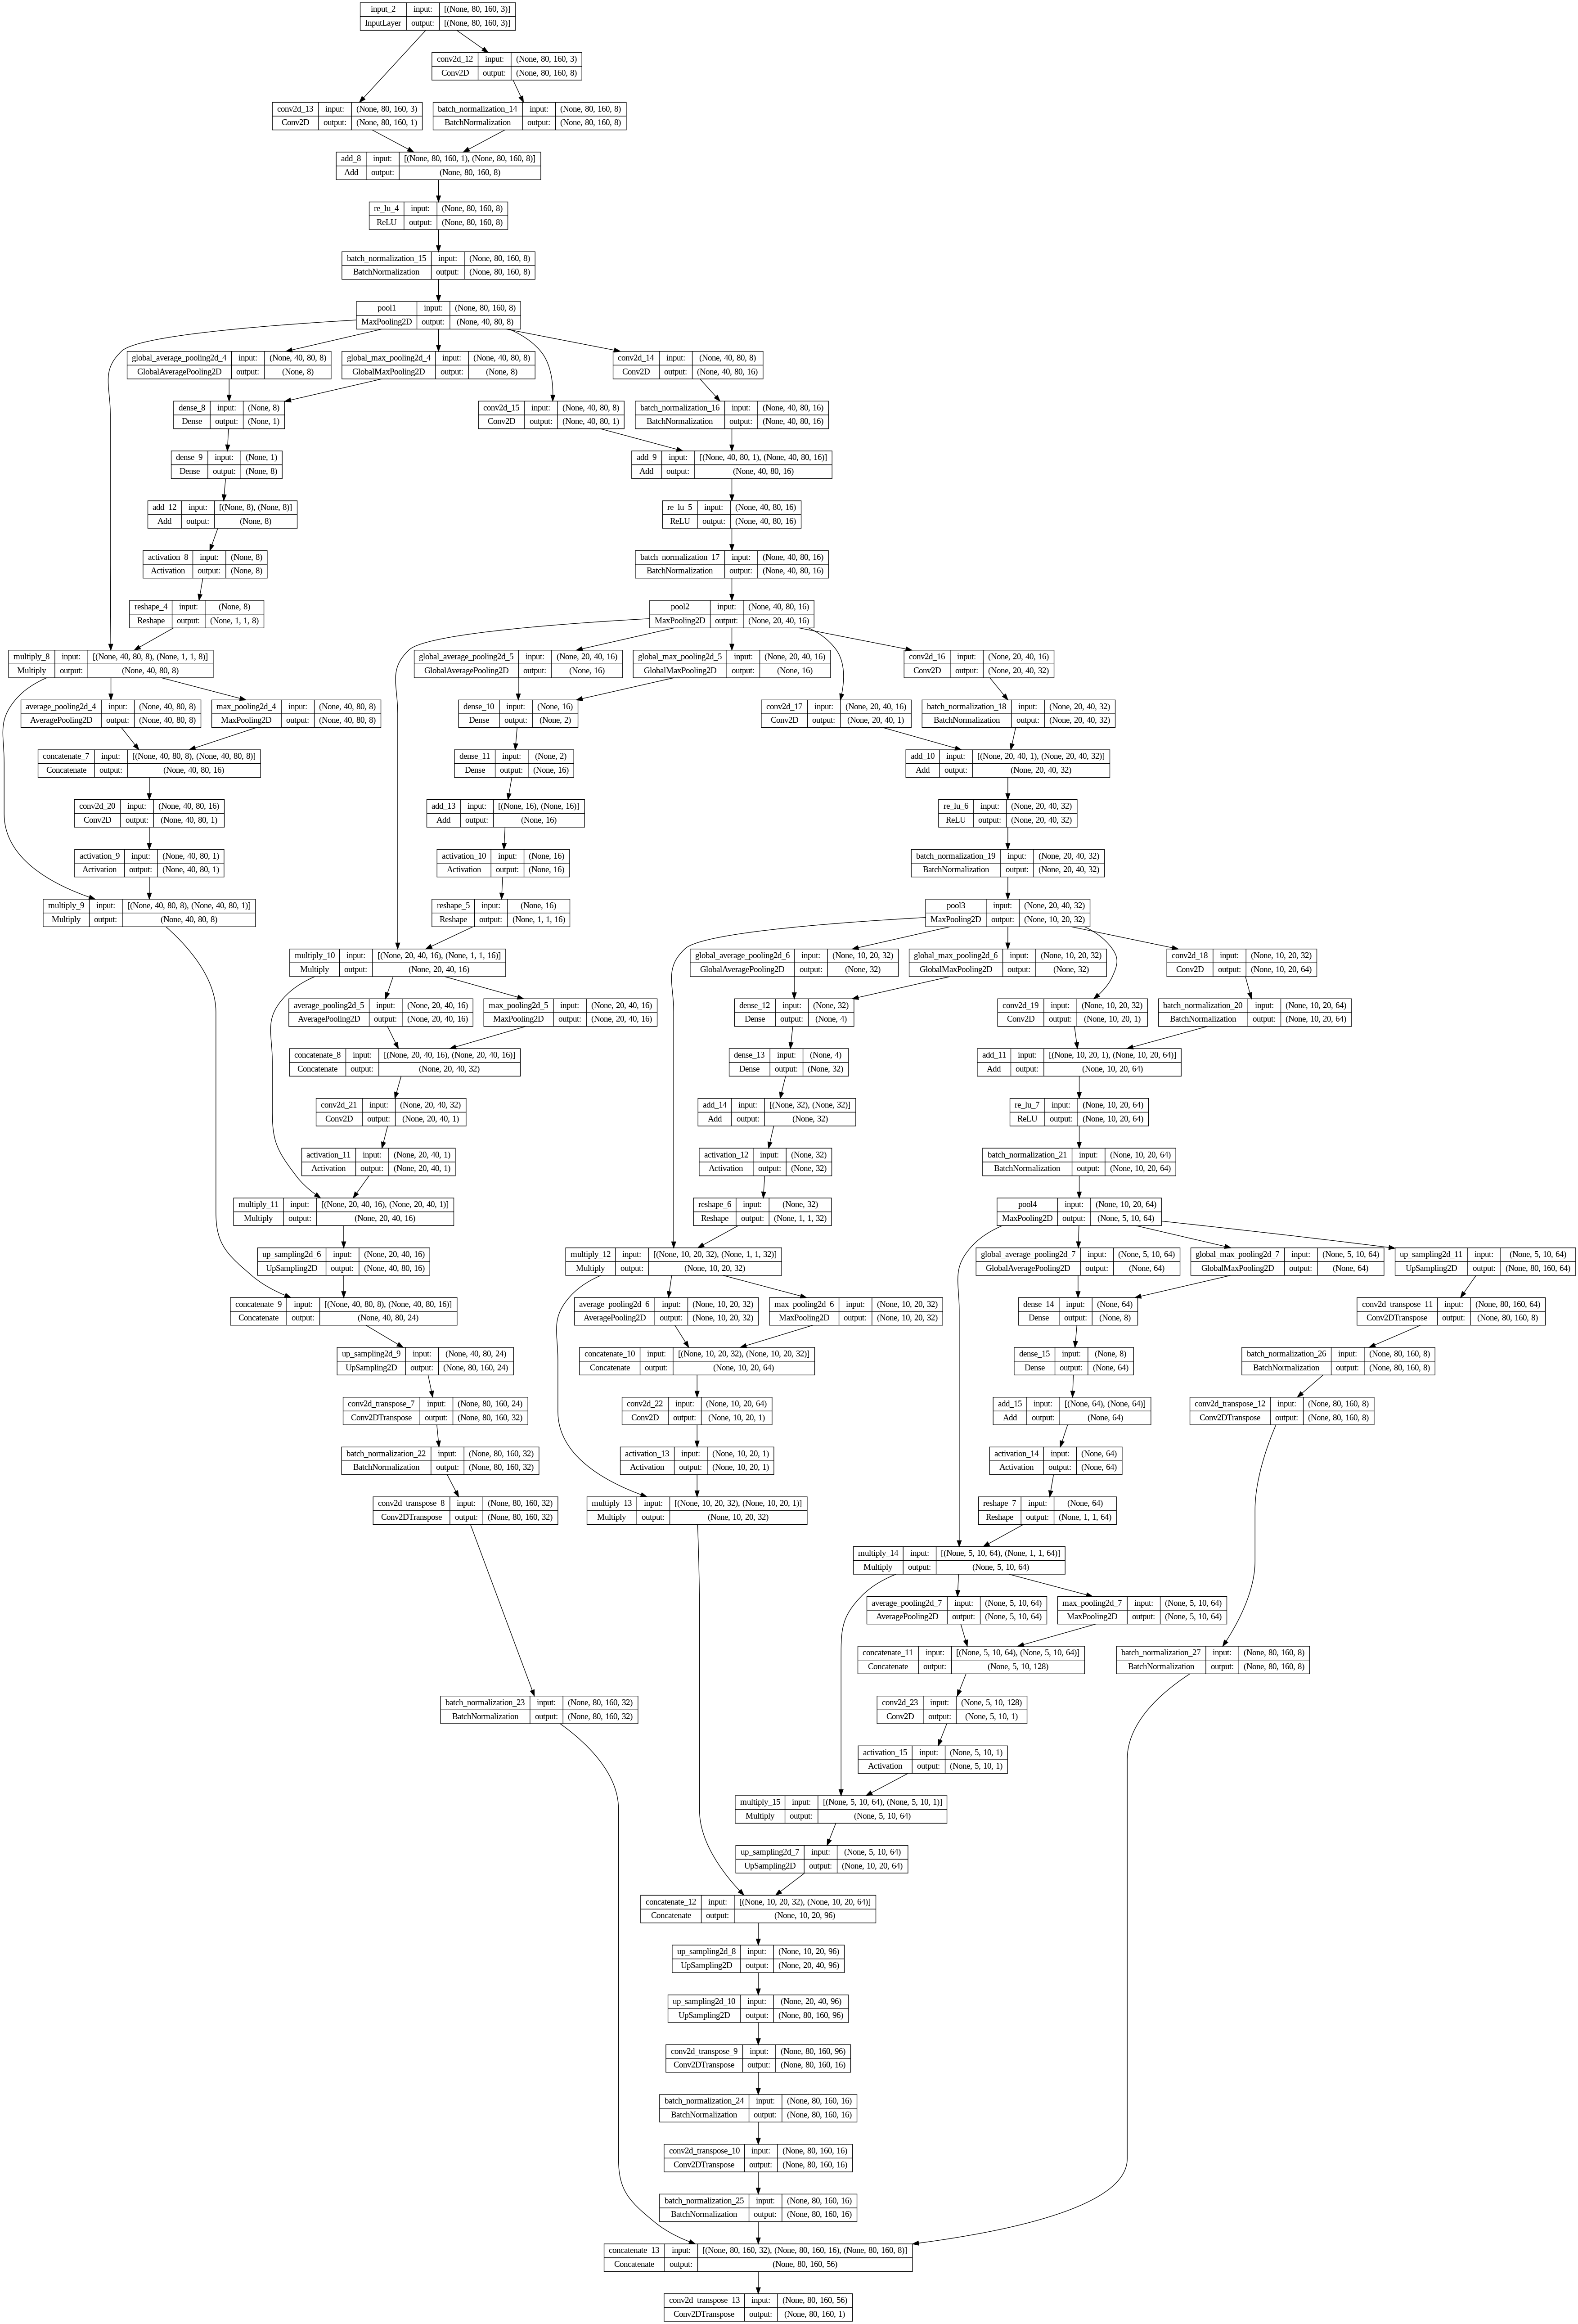

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='LLDNet.png',show_shapes=True)

In [ ]:
# Save and Load LLD
model.save('/content/drive/MyDrive/CMPT733/project/LLDNet.h5')
model = load_model('/content/drive/MyDrive/CMPT733/project/LLDNet.h5',custom_objects={'dice_loss':dice_loss,'IOU':IOU,'dsc':dsc,'precision_m':precision_m, 'recall_m':recall_m, 'f1_m':f1_m})


In [ ]:
# train LLD
history=model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,
epochs=epochs, verbose=1, validation_data=(X_val, y_val))

model.save('/content/drive/MyDrive/CMPT733/project/LLDNet.h5')

Epoch 1/100


<ipython-input-22-cdbf5e8f1af1>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,


299/299 [==============================] - 42s 97ms/step - loss: 0.1224 - dsc: 0.8451 - accuracy: 0.9356 - IOU: 0.8527 - precision_m: 0.9055 - recall_m: 0.9220 - f1_m: 0.9111 - val_loss: 0.0712 - val_dsc: 0.8941 - val_accuracy: 0.9488 - val_IOU: 0.8830 - val_precision_m: 0.9655 - val_recall_m: 0.9026 - val_f1_m: 0.9329
Epoch 2/100
299/299 [==============================] - 27s 91ms/step - loss: 0.0504 - dsc: 0.9343 - accuracy: 0.9560 - IOU: 0.9254 - precision_m: 0.9613 - recall_m: 0.9505 - f1_m: 0.9558 - val_loss: 0.0458 - val_dsc: 0.9438 - val_accuracy: 0.9568 - val_IOU: 0.9294 - val_precision_m: 0.9631 - val_recall_m: 0.9534 - val_f1_m: 0.9582
Epoch 3/100
299/299 [==============================] - 28s 92ms/step - loss: 0.0411 - dsc: 0.9459 - accuracy: 0.9581 - IOU: 0.9368 - precision_m: 0.9655 - recall_m: 0.9579 - f1_m: 0.9616 - val_loss: 0.0510 - val_dsc: 0.9355 - val_accuracy: 0.9549 - val_IOU: 0.9142 - val_precision_m: 0.9763 - val_recall_m: 0.9255 - val_f1_m: 0.9502
Epoch 4/100
2

# PSPNet

In [ ]:
# PSPNet
from keras.layers import Convolution2D,BatchNormalization,ReLU,LeakyReLU,Add,Activation

def conv_block(X,filters,block):
    # resiudal block with dilated convolutions
    # add skip connection at last after doing convoluion operation to input X
    
    b = 'block_'+str(block)+'_'
    f1,f2,f3 = filters
    X_skip = X
    # block_a
    X = Convolution2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'a')(X)
    X = BatchNormalization(name=b+'batch_norm_a')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_a')(X)
    # block_b
    X = Convolution2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
                      padding='same',kernel_initializer='he_normal',name=b+'b')(X)
    X = BatchNormalization(name=b+'batch_norm_b')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_b')(X)
    # block_c
    X = Convolution2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'c')(X)
    X = BatchNormalization(name=b+'batch_norm_c')(X)
    # skip_conv
    X_skip = Convolution2D(filters=f3,kernel_size=(3,3),padding='same',name=b+'skip_conv')(X_skip)
    X_skip = BatchNormalization(name=b+'batch_norm_skip_conv')(X_skip)
    # block_c + skip_conv
    X = Add(name=b+'add')([X,X_skip])
    X = ReLU(name=b+'relu')(X)
    return X
    
def base_feature_maps(input_layer):
    # base covolution module to get input image feature maps 
    
    # block_1
    base = conv_block(input_layer,[32,32,64],'1')
    # block_2
    base = conv_block(base,[64,64,128],'2')
    # block_3
    base = conv_block(base,[128,128,256],'3')
    return base

def pyramid_feature_maps(input_layer):
    # pyramid pooling module
    
    base = base_feature_maps(input_layer)
    # red
    red = GlobalAveragePooling2D(name='red_pool')(base)
    red = tf.keras.layers.Reshape((1,1,256))(red)
    red = Convolution2D(filters=64,kernel_size=(1,1),name='red_1_by_1')(red)
    red = UpSampling2D(size=(80,160),interpolation='bilinear',name='red_upsampling')(red)
    # yellow
    yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = Convolution2D(filters=64,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    # blue
    blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = Convolution2D(filters=64,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    # green
    green = AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = Convolution2D(filters=64,kernel_size=(1,1),name='green_1_by_1')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)
    # base + red + yellow + blue + green
    return tf.keras.layers.concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer):
    X = pyramid_feature_maps(input_layer)
    X = Convolution2D(filters=1,kernel_size=3,padding='same',name='last_conv_3_by_3')(X)
    X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    X = Activation('sigmoid',name='last_conv_relu')(X)
    #X = tf.keras.layers.Flatten(name='last_conv_flatten')(X)
    return X

output_layer = last_conv_module(inputs)

In [ ]:
#PSPNet

model = Model(inputs, outputs=output_layer)
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)
opt = keras.optimizers.Adam()
model.compile(optimizer=opt,  loss = "binary_crossentropy", metrics = ['dsc','accuracy', 'IOU','precision_m', 'recall_m', 'f1_m'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 block_1_a (Conv2D)             (None, 80, 160, 32)  128         ['input_1[0][0]']                
                                                                                                  
 block_1_batch_norm_a (BatchNor  (None, 80, 160, 32)  128        ['block_1_a[0][0]']              
 malization)                                                                                      
                                                                                            

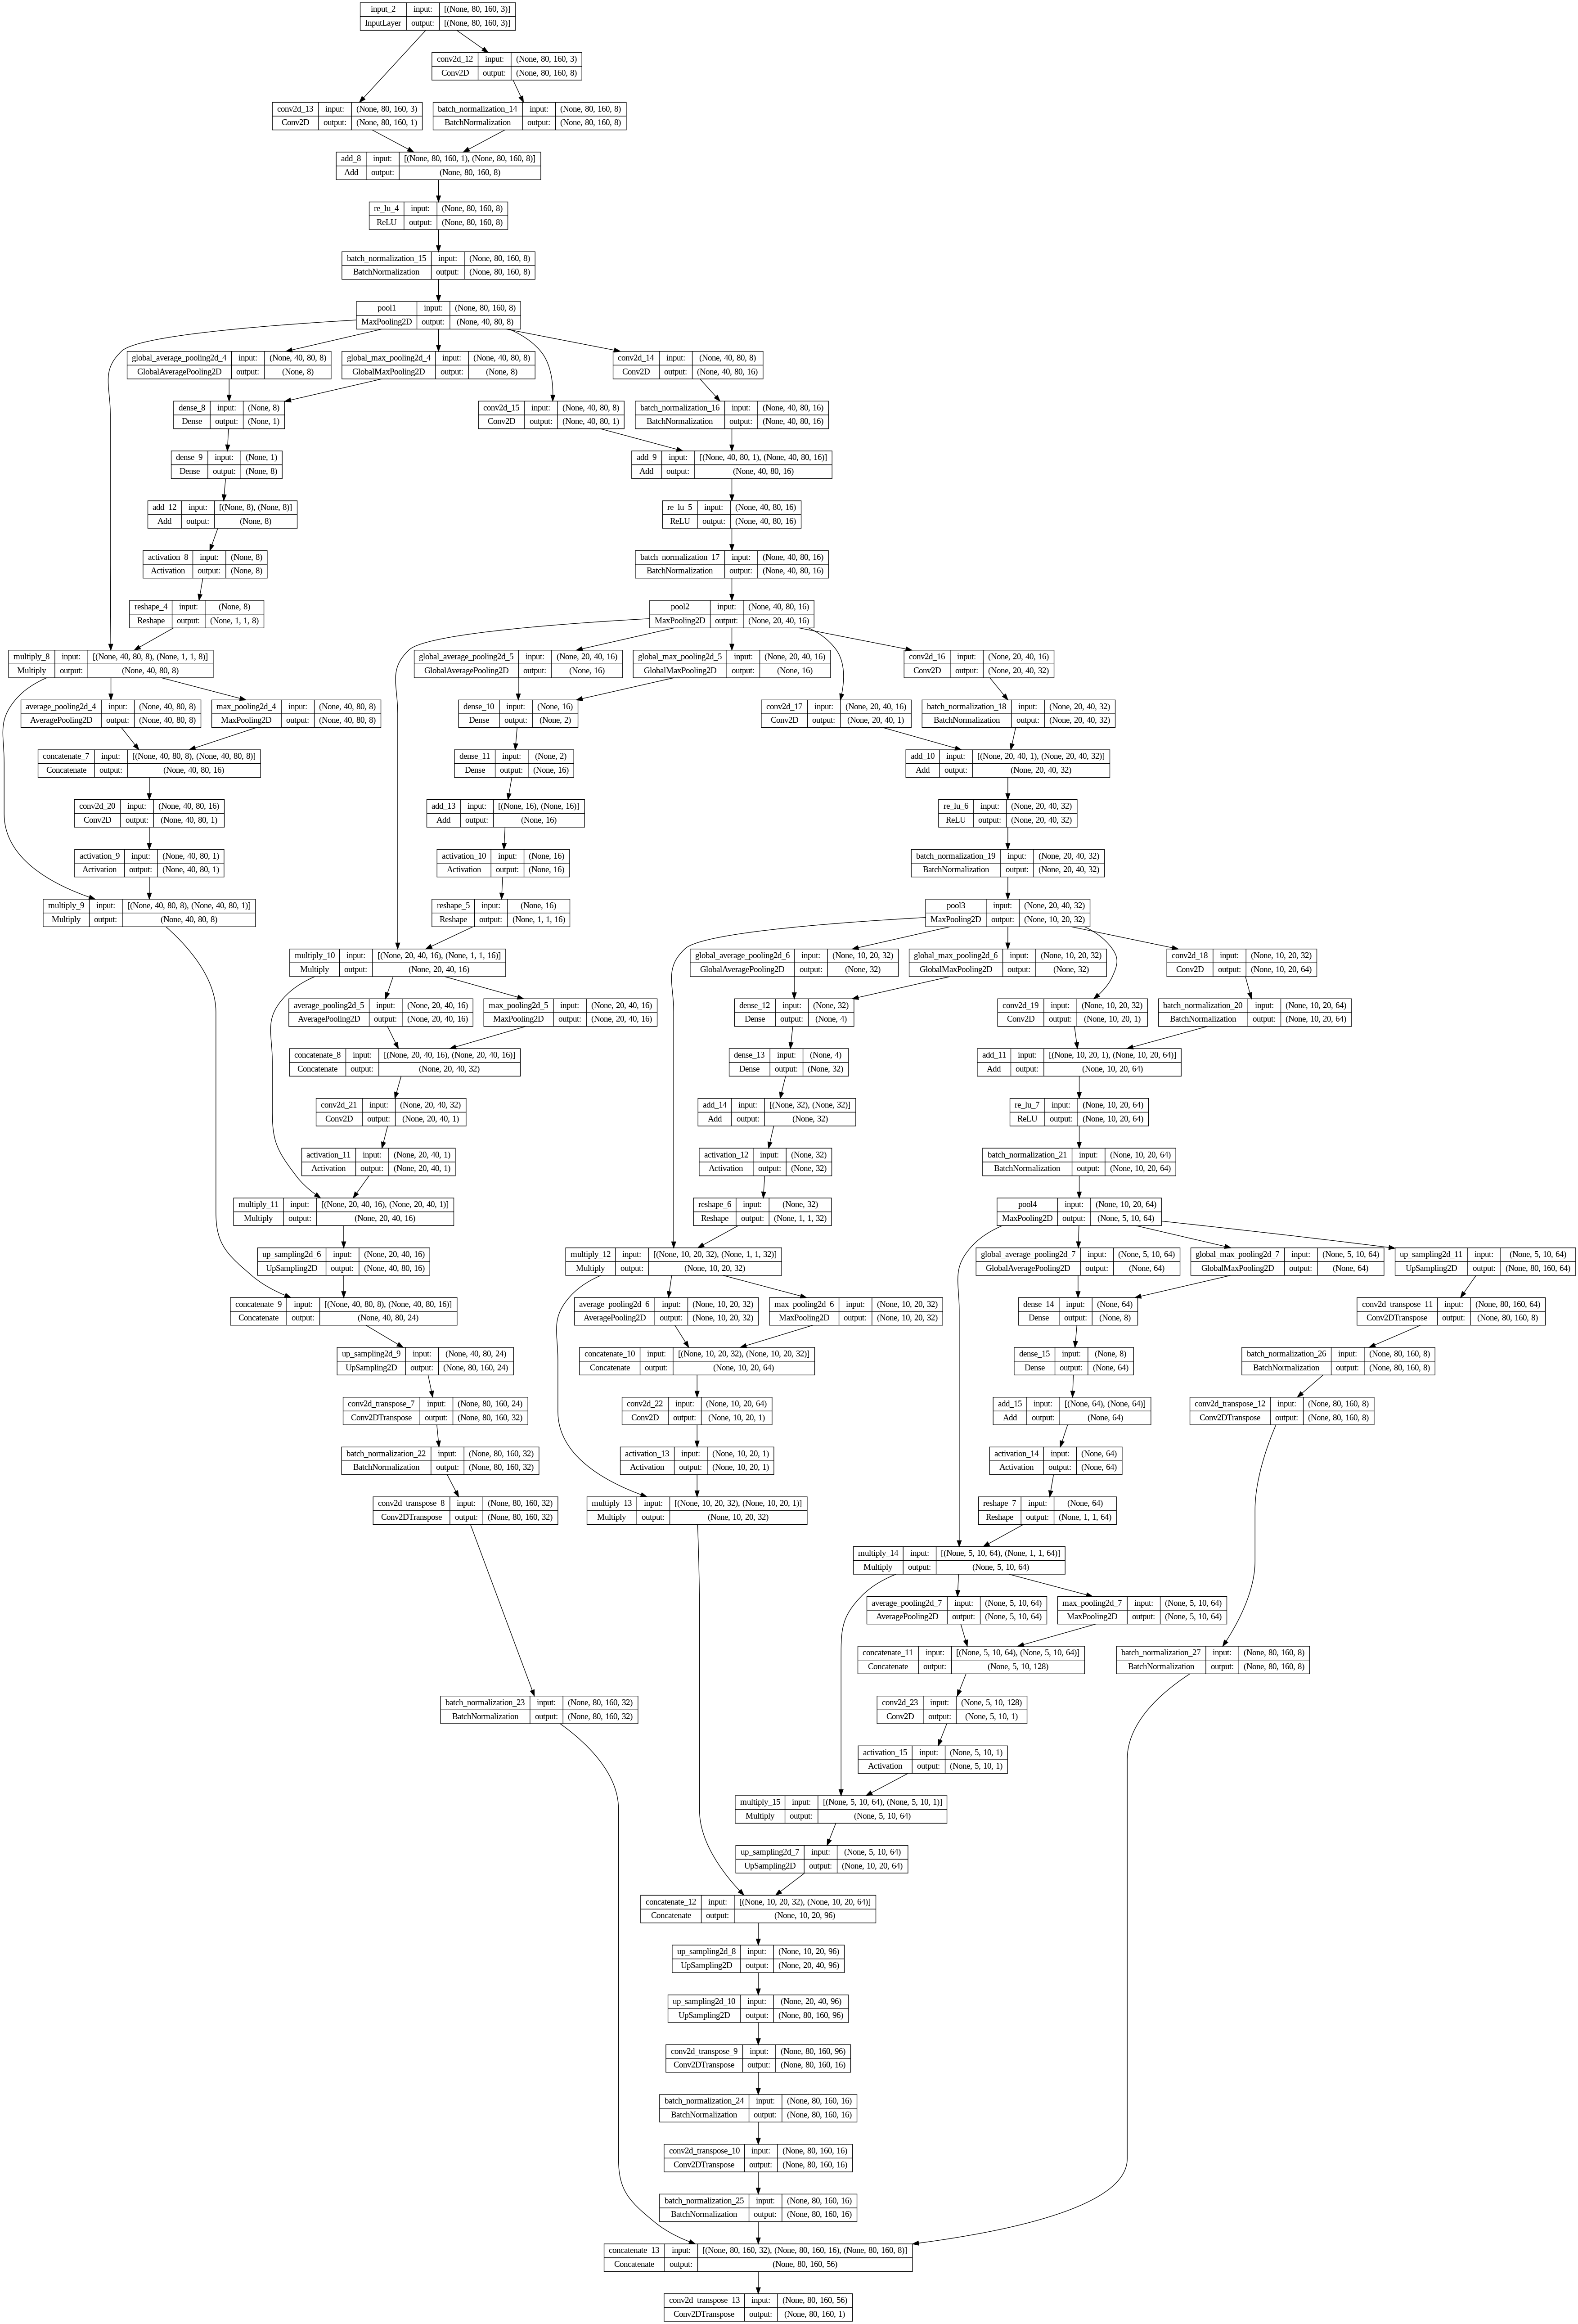

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='PSPNet.png',show_shapes=True)

In [ ]:
# Save and Load PSPNet
model.save('/content/drive/MyDrive/CMPT733/project/PSPNet.h5')
model = load_model('/content/drive/MyDrive/CMPT733/project/PSPNet.h5',custom_objects={'dice_loss':dice_loss,'IOU':IOU,'dsc':dsc,'precision_m':precision_m, 'recall_m':recall_m, 'f1_m':f1_m})


In [ ]:
# train PSPNet
history=model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,
epochs=epochs, verbose=1, validation_data=(X_val, y_val))

model.save('/content/drive/MyDrive/CMPT733/project/PSPNet.h5')

Epoch 1/100


<ipython-input-16-adf98a577e0a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,


299/299 [==============================] - 239s 708ms/step - loss: 0.4031 - dsc: 0.5317 - accuracy: 0.8920 - IOU: 0.7311 - precision_m: 0.7449 - recall_m: 0.9440 - f1_m: 0.8292 - val_loss: 0.4669 - val_dsc: 0.4794 - val_accuracy: 0.9083 - val_IOU: 0.7576 - val_precision_m: 0.7818 - val_recall_m: 0.9317 - val_f1_m: 0.8499
Epoch 2/100
299/299 [==============================] - 202s 674ms/step - loss: 0.2790 - dsc: 0.6163 - accuracy: 0.9401 - IOU: 0.8664 - precision_m: 0.8838 - recall_m: 0.9557 - f1_m: 0.9179 - val_loss: 0.2913 - val_dsc: 0.5855 - val_accuracy: 0.9420 - val_IOU: 0.8668 - val_precision_m: 0.9284 - val_recall_m: 0.9099 - val_f1_m: 0.9190
Epoch 3/100
299/299 [==============================] - 202s 673ms/step - loss: 0.2113 - dsc: 0.6789 - accuracy: 0.9494 - IOU: 0.9035 - precision_m: 0.9238 - recall_m: 0.9568 - f1_m: 0.9398 - val_loss: 0.1759 - val_dsc: 0.7312 - val_accuracy: 0.9372 - val_IOU: 0.8567 - val_precision_m: 0.8869 - val_recall_m: 0.9448 - val_f1_m: 0.9148
Epoch 4

# plot loss and accuracy

In [ ]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

In [ ]:
from numpy import savetxt
savetxt('train_loss_LLD.csv', train_loss, delimiter=',')
savetxt('valid_loss_LLD.csv', valid_loss, delimiter=',')

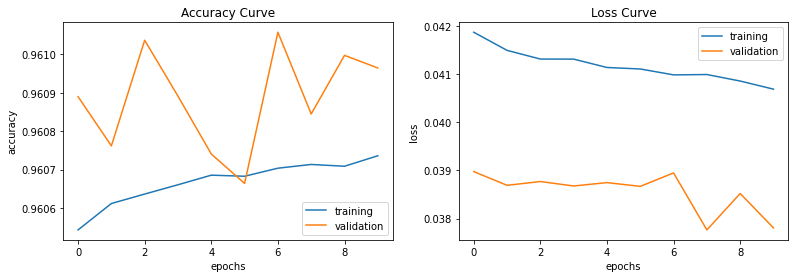

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes = axes.flatten()

axes[0].plot(train_acc, label='training')
axes[0].plot(valid_acc, label='validation')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()


axes[1].plot(train_loss, label='training')
axes[1].plot(valid_loss, label='validation')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

# test

In [ ]:
# test LLD model
model = load_model('/content/drive/MyDrive/CMPT733/project/trained_network/LLDNet_V1.h5',custom_objects={'dice_loss':dice_loss,'IOU':IOU,'dsc':dsc,'precision_m':precision_m, 'recall_m':recall_m, 'f1_m':f1_m})

results = model.evaluate(X_test, y_test)

94/94 [==============================] - 4s 31ms/step - loss: 0.0179 - dsc: 0.9781 - accuracy: 0.9636 - IOU: 0.9771 - precision_m: 0.9777 - recall_m: 0.9856 - f1_m: 0.9816


In [ ]:
# test LLDNet with deeper ResBlocks model
model = load_model('/content/drive/MyDrive/CMPT733/project/trained_network/LLDNet_V4.h5',custom_objects={'dice_loss':dice_loss,'IOU':IOU,'dsc':dsc,'precision_m':precision_m, 'recall_m':recall_m, 'f1_m':f1_m})

results = model.evaluate(X_test, y_test)

94/94 [==============================] - 4s 35ms/step - loss: 0.0161 - dsc: 0.9793 - accuracy: 0.9640 - IOU: 0.9809 - precision_m: 0.9823 - recall_m: 0.9834 - f1_m: 0.9829


In [ ]:
# test simplified LLDNet model
model = load_model('/content/drive/MyDrive/CMPT733/project/trained_network/LLDNet_simplified.h5',custom_objects={'dice_loss':dice_loss,'IOU':IOU,'dsc':dsc,'precision_m':precision_m, 'recall_m':recall_m, 'f1_m':f1_m})

results = model.evaluate(X_test, y_test)

94/94 [==============================] - 5s 45ms/step - loss: 0.0173 - dsc: 0.9778 - accuracy: 0.9638 - IOU: 0.9778 - precision_m: 0.9843 - recall_m: 0.9794 - f1_m: 0.9818


In [ ]:
# test PSPNet model
model = load_model('/content/drive/MyDrive/CMPT733/project/trained_network/PSPNet.h5',custom_objects={'dice_loss':dice_loss,'IOU':IOU,'dsc':dsc,'precision_m':precision_m, 'recall_m':recall_m, 'f1_m':f1_m})

results = model.evaluate(X_test, y_test)

94/94 [==============================] - 21s 212ms/step - loss: 0.0204 - dsc: 0.9700 - accuracy: 0.9632 - IOU: 0.9734 - precision_m: 0.9786 - recall_m: 0.9783 - f1_m: 0.9784


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jan 22 20:06:30 2022

@author: USER
"""


# -*- coding: utf-8 -*-
"""
Created on Mon Dec 27 10:25:25 2021

@author: USER
"""

import numpy as np
import cv2
#from scipy.misc import imresize
import time
import sys
import tensorflow as tf
from keras.models import load_model
import keras.backend as K

def dsc(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def dice_loss(y_true, y_pred):
        return 1.0 - dsc(y_true, y_pred)


def IOU(y_true, y_pred):

        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)
    
        thresh = 0.5

        y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
        y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')

        union = K.sum(K.maximum(y_true, y_pred)) + K.epsilon()
        intersection = K.sum(K.minimum(y_true, y_pred)) + K.epsilon()

        iou = intersection/union

        return iou


model = load_model('/content/drive/MyDrive/CMPT733/project/trained_network/LLDNet_simplified_V2.h5',custom_objects={'dice_loss':dice_loss,'IOU':IOU,'dsc':dsc,'precision_m':precision_m, 'recall_m':recall_m, 'f1_m':f1_m})

# Class to average lanes with
class Lanes():
    def __init__(self):
        self.recent_fit = []
        self.avg_fit = []



video_capture = cv2.VideoCapture("/content/drive/MyDrive/CMPT733/project/Video.mp4")

video_capture.set(3, 640)
video_capture.set(4, 480)
fps = video_capture.get(cv2.CAP_PROP_FPS)
#print("a:",fps)

     
fourcc=cv2.VideoWriter_fourcc(*'XVID')
out=cv2.VideoWriter('output.avi' , fourcc , 20.0 , (640,480))
count = 0
time_taken = []


    
while(video_capture.isOpened()):
   lanes = Lanes()


 

    # Capture the frames
   ret,image = video_capture.read()
   if not ret:
       print("Can't receive frame (stream end?). Exiting ...")
       break
   
   if ret:
           small_img = cv2.resize(image, (160,80))
           small_img = np.array(small_img)
         
           small_img = small_img[None,:,:,:]
           start_time=time.time()
           prediction = model.predict(small_img)[0] * 255
           total_time = time.time() - start_time
           
           fps = 1/(time.time()-start_time)
           
           fps = int(fps)
           print(fps)
          
           lanes.recent_fit.append(prediction)
     # Only using last five for average
           if len(lanes.recent_fit) > 5:
              lanes.recent_fit = lanes.recent_fit[1:]

    # Calculate average detection
           lanes.avg_fit = np.mean(np.array([i for i in lanes.recent_fit]), axis = 0)

    # Generate fake R & B color dimensions, stack with G
           blanks = np.zeros_like(lanes.avg_fit).astype(np.uint8)
           lane_drawn = np.dstack((blanks, lanes.avg_fit, blanks))

    # Re-size to match the original image
           lane_image = cv2.resize(lane_drawn, (640,480))
           
          
   
  

   

 
               
   
   
           image = cv2.resize(image, (640,480))
           lane_image = lane_image.astype(np.uint8)

           result = cv2.addWeighted(image, 1, lane_image, 1, 0)
           
           out.write(result)
           #cv2.imshow('r',result)
           
  
  
           if cv2.waitKey(1) & 0xFF == ord('q'):

                 break
       
             
    
       

   
   
    


video_capture.release()
out.release()
cv2.destroyAllWindows()

1/1 [==============================] - 1s 978ms/step
0
1/1 [==============================] - 0s 21ms/step
17
1/1 [==============================] - 0s 21ms/step
16
1/1 [==============================] - 0s 21ms/step
18
1/1 [==============================] - 0s 20ms/step
15
1/1 [==============================] - 0s 22ms/step
17
1/1 [==============================] - 0s 19ms/step
19
1/1 [==============================] - 0s 20ms/step
16
1/1 [==============================] - 0s 21ms/step
16
1/1 [==============================] - 0s 21ms/step
18
1/1 [==============================] - 0s 19ms/step
17
1/1 [==============================] - 0s 20ms/step
19
1/1 [==============================] - 0s 20ms/step
19
1/1 [==============================] - 0s 21ms/step
18
1/1 [==============================] - 0s 20ms/step
18
1/1 [==============================] - 0s 19ms/step
18
1/1 [==============================] - 0s 20ms/step
15
1/1 [==============================] - 0s 21ms/step
16
1/1 [=====

# pipeline

In [ ]:
# This is the part II of Lane and Vehicle Detection Pipeline
# Input: images with vehicles annotated
# Output: images with lane and vehicle annotated

model = load_model('/content/drive/MyDrive/CMPT733/project/trained_network/LLDNet_V2.h5',custom_objects={'dice_loss':dice_loss,'IOU':IOU,'dsc':dsc,'precision_m':precision_m, 'recall_m':recall_m, 'f1_m':f1_m})

for i in range(6):
  index = i+1
  image = cv2.imread('/content/drive/MyDrive/CMPT733/project/vehicle detection/original_regular/test' + str(index) + '.jpg')
  small_img = cv2.resize(image, (160,80))

  small_img = np.array(small_img)
          
  small_img = small_img[None,:,:,:]
  start_time=time.time()
  prediction = model.predict(small_img)[0] * 255
  total_time = time.time() - start_time
            
  fps = 1/(time.time()-start_time)
            
  fps = int(fps)
  print(fps)
            
  lanes.recent_fit.append(prediction)
  # Only using last five for average
  if len(lanes.recent_fit) > 5:
    lanes.recent_fit = lanes.recent_fit[1:]

  # Calculate average detection
  lanes.avg_fit = np.mean(np.array([i for i in lanes.recent_fit]), axis = 0)

  # Generate fake R & B color dimensions, stack with G
  blanks = np.zeros_like(lanes.avg_fit).astype(np.uint8)
  lane_drawn = np.dstack((blanks, lanes.avg_fit, blanks))

  # Re-size to match the original image
  lane_image = cv2.resize(lane_drawn, (640,480))
            
            
    
  image = cv2.resize(image, (640,480))
  lane_image = lane_image.astype(np.uint8)

  result = cv2.addWeighted(image, 1, lane_image, 1, 0)
            
  cv2.imwrite('output' + str(index) + '.jpg', result)
  #cv2.imshow('r',result)


1/1 [==============================] - 1s 743ms/step
1
1/1 [==============================] - 0s 23ms/step
17
1/1 [==============================] - 0s 23ms/step
17
1/1 [==============================] - 0s 24ms/step
16
1/1 [==============================] - 0s 24ms/step
17
1/1 [==============================] - 0s 22ms/step
17
